#### I'm not the proudest of the way I coded this up, but it gets the job done... Please tell me if you'd like me to make it look better!

Note only chiral_smiles[9] is achiral

In [28]:
import morfeus
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from chiralizer import chiralizer
import sascorer
from pathlib import Path
import matplotlib.pyplot as plt
import os
from adjustText import adjust_text
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn.functional as f

In [6]:
smiles_file = open('sidechain_smiles.smi', 'r')
smiles = smiles_file.read().splitlines()

## analyzing properties of chiral peptoids

separating chiral and achiral peptoids

In [83]:
chiral_smiles = [chiralizer(smiles[i])[1] for i in range(len(smiles)) if chiralizer(smiles[i])[0]]

In [84]:
chiral_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/')

In [86]:
del chiral_smiles[9] # remove achiral flaw ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']

In [87]:
chiral_smiles

[['N[C@H](C)CC', 'N[C@@H](C)CC'],
 ['N[C@H](Cc1ccccc1)C(=O)Nc1ccccc1', 'N[C@@H](Cc1ccccc1)C(=O)Nc1ccccc1'],
 ['N[C@H](C)c1ccccc1', 'N[C@@H](C)c1ccccc1'],
 ['N[C@H](C)c1ccc([O-])cc1', 'N[C@@H](C)c1ccc([O-])cc1'],
 ['N[C@H](C)c1ccc(OC)cc1', 'N[C@@H](C)c1ccc(OC)cc1'],
 ['N[C@H](Cc1ccccc1)C(=O)OC(C)C', 'N[C@@H](Cc1ccccc1)C(=O)OC(C)C'],
 ['N[C@H](C)c1cc[n+](C)cc1', 'N[C@@H](C)c1cc[n+](C)cc1'],
 ['N[C@H](Cc1ccccc1)C(=O)NC(C)C', 'N[C@@H](Cc1ccccc1)C(=O)NC(C)C'],
 ['N[C@H](C)c1ccc(N(=O)=O)cc1', 'N[C@@H](C)c1ccc(N(=O)=O)cc1'],
 ['N[C@H](Cc1ccccc1)C(=O)Nc1ccc(N(=O)=O)cc1',
  'N[C@@H](Cc1ccccc1)C(=O)Nc1ccc(N(=O)=O)cc1'],
 ['N[C@H](Cc1ccccc1)C(=O)NCC(F)(F)F', 'N[C@@H](Cc1ccccc1)C(=O)NCC(F)(F)F'],
 ['N[C@H](C)c1ccc(Cl)cc1', 'N[C@@H](C)c1ccc(Cl)cc1'],
 ['N[C@H](C)c1c(F)c(F)c(F)c(F)c1(F)', 'N[C@@H](C)c1c(F)c(F)c(F)c(F)c1(F)'],
 ['N[C@H](C)c1ccc(F)cc1', 'N[C@@H](C)c1ccc(F)cc1'],
 ['N[C@H](C)c1c2ccccc2ccc1', 'N[C@@H](C)c1c2ccccc2ccc1'],
 ['N[C@H](C)C1CCCCC1', 'N[C@@H](C)C1CCCCC1'],
 ['N[C@H](Cc1ccccc1)

converting smiles to xyz done on conda command line

### calculating properties

In [77]:
# list of properties
bv_list, disp_list, sasa_list = [], [], []

for filename in os.listdir(chiral_directory):
    if filename != 'mol10a.xyz' and filename != 'mol10b.xyz':
        if filename.endswith('.xyz'):
            elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/' + filename)

            # appending results to lists
            bv_list.append((os.path.splitext(filename)[0], morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume))
    #        cone_list.append((os.path.splitext(filename)[0], morfeus.ConeAngle(elements, coordinates, 1).cone_angle)) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
            disp_list.append((os.path.splitext(filename)[0], morfeus.Dispersion(elements, coordinates).p_int)) # P_int value
            sasa_list.append((os.path.splitext(filename)[0], morfeus.SASA(elements, coordinates).area)) # 

In [78]:
left_bonds = []
right_bonds = []
for chiral_mol in chiral_smiles:
    if chiral_mol != ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']: # achiral molecule, flaw in chiralizer.py
        mol1 = rdkit.Chem.MolFromSmiles(chiral_mol[0])
        mol2 = rdkit.Chem.MolFromSmiles(chiral_mol[1])
        left_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))
        right_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol2))

In [79]:
len(bv_list)

34

reading xtb

In [80]:
chiral_xtb_np = np.load('data/chiral_xtb_data.npy', allow_pickle=True) 

In [81]:
chiral_xtb = chiral_xtb_np.tolist() # LUMO, Q+, H_idx

In [88]:
del chiral_xtb[18]
del chiral_xtb[19]

In [89]:
left_xtb = []
right_xtb = []

while chiral_xtb:
    right_xtb.append(chiral_xtb.pop())
    left_xtb.append(chiral_xtb.pop())

In [90]:
left_xtb.reverse()
right_xtb.reverse()

In [91]:
left_lumo = [i[0] for i in left_xtb]
left_Q = [i[1] for i in left_xtb]
left_H = [i[2] for i in left_xtb]

right_lumo = [i[0] for i in right_xtb]
right_Q = [i[1] for i in right_xtb]
right_H = [i[2] for i in right_xtb]

sa score

In [92]:
sa_list = []
left_sa = []
right_sa = []

for i in chiral_smiles:
    if i != ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']: # achiral molecule, flaw in chiralizer.py
        left = rdkit.Chem.MolFromSmiles(i[0])
        right = rdkit.Chem.MolFromSmiles(i[1])

        l_sco = sascorer.calculateScore(left)
        r_sco = sascorer.calculateScore(right)

        sa_list.append(l_sco)
        sa_list.append(r_sco)
      
while sa_list:
    right_sa.append(sa_list.pop())
    left_sa.append(sa_list.pop())
    
left_sa.reverse()
right_sa.reverse()

### separating left and right

In [93]:
left_bv = [i[1] for i in bv_list if 'a' in i[0]]
right_bv = [i[1] for i in bv_list if 'b' in i[0]]

left_disp = [i[1] for i in disp_list if 'a' in i[0]]
right_disp = [i[1] for i in disp_list if 'b' in i[0]]

left_sasa = [i[1] for i in sasa_list if 'a' in i[0]]
right_sasa = [i[1] for i in sasa_list if 'b' in i[0]]

In [94]:
labels = [i[0] for i in bv_list if 'a' in i[0]]

### plotting

In [95]:
chiral_props = {
    'buried volume' : (left_bv, right_bv),
    'SASA area' : (left_sasa, right_sasa),
    'dispersion descriptor p_int' : (left_disp, right_disp),
    'LUMO' : (left_lumo, right_lumo),
    'Q+' : (left_Q, right_Q),
    '# H+ bond donors' : (left_bonds, right_bonds),
    'synthetic accessibility score' : (left_sa, right_sa)
} 

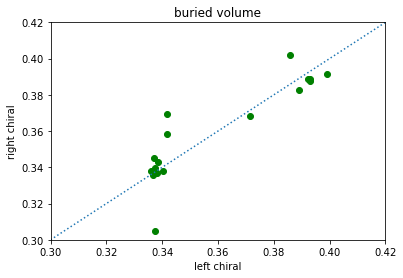

tensor MSE: tensor(0.0166, dtype=torch.float64)
manual MSE:  0.016561908749077772


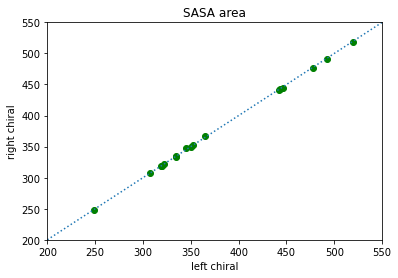

tensor MSE: tensor(2.0350e-05, dtype=torch.float64)
manual MSE:  2.0350176820721944e-05


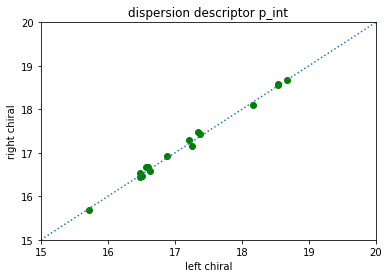

tensor MSE: tensor(0.0002, dtype=torch.float64)
manual MSE:  0.0001829308165733891


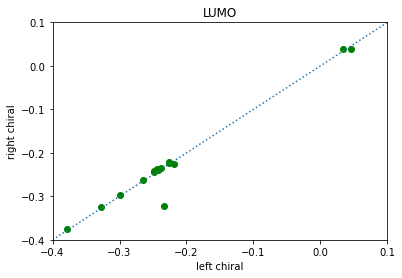

tensor MSE: tensor(0.0027, dtype=torch.float64)
manual MSE:  0.0026878335776740997


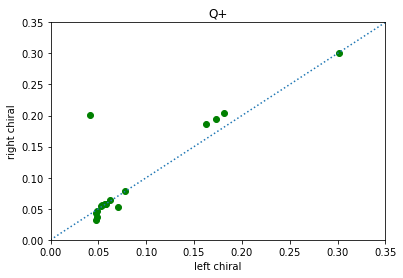

tensor MSE: tensor(0.0225, dtype=torch.float64)
manual MSE:  0.02252030548398492


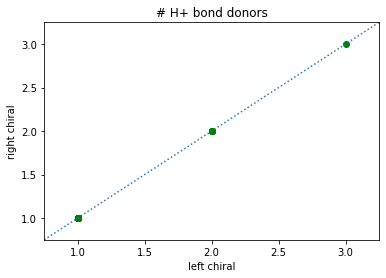

tensor MSE: tensor(0., dtype=torch.float64)
manual MSE:  0.0


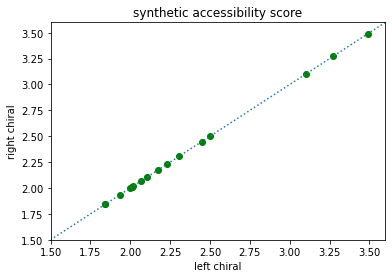

tensor MSE: tensor(0., dtype=torch.float64)
manual MSE:  0.0


In [103]:
for key in chiral_props:
    plt.scatter(chiral_props[key][0], chiral_props[key][1], c='g', )
    plt.axline([0, 0], [1, 1], linestyle=':')
    plt.xlabel("left chiral")
    plt.ylabel("right chiral")
    plt.title(key)
    if key == "buried volume":
        plt.axis([0.3, 0.42, 0.3, 0.42])
    elif key == "dispersion descriptor p_int":
        plt.axis([15, 20, 15, 20])
    elif key == "SASA area":
        plt.axis([200, 550, 200, 550])
    elif key == "LUMO":
        plt.axis([-0.4, 0.1, -0.4, 0.1])
    elif key == "Q+":
        plt.axis([0.0, 0.35, 0.0, 0.35])
    elif key == "synthetic accessibility score":
        plt.axis([1.5, 3.6, 1.5, 3.6])
    elif key == "# H+ bond donors":
        plt.axis([0.75, 3.25, 0.75, 3.25])
        
    plt.show()
        
    # MSE
    scaler = MinMaxScaler()
    all_data = np.array(chiral_props[key][0] + chiral_props[key][1])
    scaled_data = scaler.fit_transform(all_data.reshape(-1, 1))
    
    left_prop = scaled_data[:17]
    right_prop = scaled_data[17:]

    print("tensor MSE:", f.mse_loss(torch.tensor(left_prop), torch.tensor(right_prop)))
    print("manual MSE: ", np.sum((left_prop - right_prop) ** 2) / 17)
    
#    texts = [plt.text(chiral_props[key][0][i], chiral_props[key][1][i], label.replace("a", "")) for i, 
#             label in enumerate(labels)
#            ]
#    adjust_text(texts)
#     for i, label in enumerate(labels):
#         plt.annotate(label.replace("a", ""), (chiral_props[key][0][i], chiral_props[key][1][i]))

## analyzing properties of N atom

### calculating methyl props

In [104]:
methyl_smiles_file = open('methyl_smiles.smi', 'r')
methyl_smiles = methyl_smiles_file.read().splitlines()

In [105]:
methyl_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/methyl_xyz/')

In [106]:
# list of properties
bv_methyl, disp_methyl, sasa_methyl = [], [], []

for filename in os.listdir(methyl_directory):
    if filename.endswith('.xyz'):
        elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/methyl_xyz/' + filename)

        # appending results to lists
        bv_methyl.append(morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)
#        cone_methyl.append(morfeus.ConeAngle(elements, coordinates, 1).cone_angle) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
        disp_methyl.append(morfeus.Dispersion(elements, coordinates).atom_p_int[1]) # P_int value
        sasa_methyl.append(morfeus.SASA(elements, coordinates).area)
#        xtb_methyl.append(morfeus.XTB(elements,coordinates).get_ip(corrected=True)) # corrected ionization potential   # need to dl xtra to work                      

In [107]:
methyl_xtb = np.load('data/methyl_xtb_data.npy', allow_pickle=True) 

In [108]:
methyl_lumo = [i[0] for i in methyl_xtb]
methyl_Q = [i[1] for i in methyl_xtb]
methyl_H = [i[2] for i in methyl_xtb]

In [109]:
methyl_bonds = []
for smile in methyl_smiles:
    mol1 = rdkit.Chem.MolFromSmiles(smile)
    methyl_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))

In [110]:
methyl_sa = []

for i in methyl_smiles:
    m = rdkit.Chem.MolFromSmiles(i)
    sco = sascorer.calculateScore(m)
    methyl_sa.append(sco)

### calculating amine properties

In [111]:
amine_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/amine_xyz/')

In [112]:
# list of properties
bv_amine, disp_amine, sasa_amine = [], [], []

for filename in os.listdir(amine_directory):
    if filename.endswith('.xyz'):
        elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/amine_xyz/' + filename)

        # appending results to lists
        bv_amine.append(morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)
#        cone_amine.append(morfeus.ConeAngle(elements, coordinates, 1).cone_angle) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
        disp_amine.append(morfeus.Dispersion(elements, coordinates).p_int) # P_int value
        sasa_amine.append(morfeus.SASA(elements, coordinates).area)
#        xtb_amine.append(morfeus.XTB(elements,coordinates).get_ip(corrected=True)) # corrected ionization potential   # need to dl xtra to work                      

In [113]:
amine_xtb = np.load('data/amine_xtb_data.npy', allow_pickle=True) 

In [114]:
amine_lumo = [i[0] for i in amine_xtb]
amine_Q = [i[1] for i in amine_xtb]
amine_H = [i[2] for i in amine_xtb]

In [115]:
amine_bonds = []
for smile in smiles:
    mol1 = rdkit.Chem.MolFromSmiles(smile)
    amine_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))

In [116]:
amine_sa = []

for i in smiles:
    m = rdkit.Chem.MolFromSmiles(i)
    sco = sascorer.calculateScore(m)
    amine_sa.append(sco)

### plotting

In [117]:
am_props = {
    'buried volume' : (bv_methyl, bv_amine),
    'SASA area' : (sasa_methyl, sasa_amine),
    'dispersion descriptor p_int' : (disp_methyl, disp_amine),
    'LUMO' : (methyl_lumo, amine_lumo),
    'Q+' : (methyl_Q, amine_Q),
    '# H+ bond donors' : (methyl_bonds, amine_bonds),
    'synthetic accessibility score' : (methyl_sa, amine_sa)
} 

In [118]:
mol_labels = ["mol" + str(i) for i in range(1, 52)]

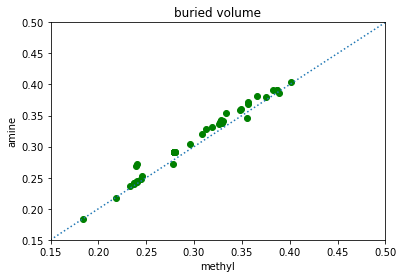

tensor MSE: tensor(0.0019, dtype=torch.float64)
manual MSE:  0.005394541813974678


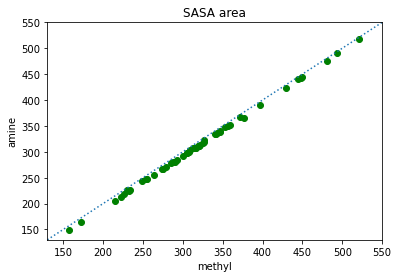

tensor MSE: tensor(0.0004, dtype=torch.float64)
manual MSE:  0.0011265907061373908


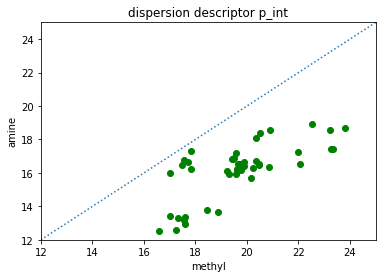

tensor MSE: tensor(0.0711, dtype=torch.float64)
manual MSE:  0.20547849890983783


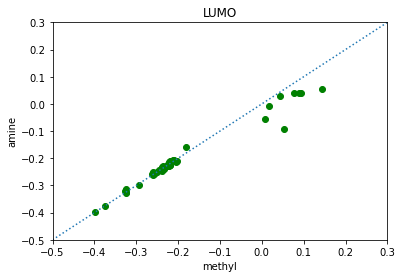

tensor MSE: tensor(0.0027, dtype=torch.float64)
manual MSE:  0.007873660406108152


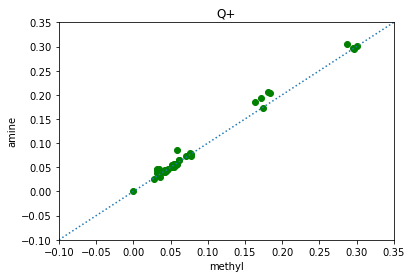

tensor MSE: tensor(0.0008, dtype=torch.float64)
manual MSE:  0.0023984565951627613


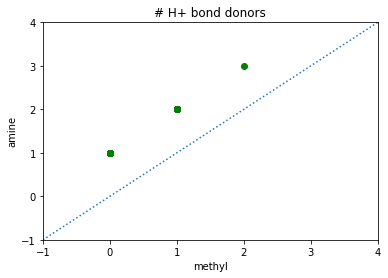

tensor MSE: tensor(0.1111, dtype=torch.float64)
manual MSE:  0.3209876543209876


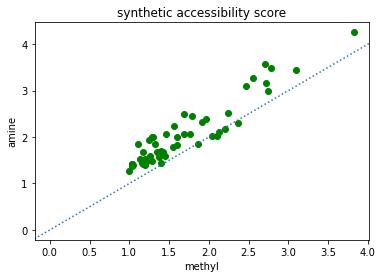

tensor MSE: tensor(0.0176, dtype=torch.float64)
manual MSE:  0.0509646246525319


In [119]:
for key in am_props:
    plt.scatter(am_props[key][0], am_props[key][1], c='g', )
    plt.axline([0, 0], [1, 1], linestyle=':')
    plt.xlabel("methyl")
    plt.ylabel("amine")
    plt.title(key)
    if key == "buried volume":
        plt.axis([0.15, 0.5, 0.15, 0.5])
    elif key == "dispersion descriptor p_int":
        plt.axis([12, 25, 12, 25])
    elif key == "SASA area":
        plt.axis([130, 550, 130, 550])
    elif key == "LUMO":
        plt.axis([-0.5, 0.3, -0.5, 0.3])
    elif key == "Q+":
        plt.axis([-0.1, 0.35, -0.1, 0.35])
    elif key == "# H+ bond donors":
        plt.axis([-1, 4, -1, 4])
    plt.show()
    
    # MSE
    scaler = MinMaxScaler()
    all_data = np.array(am_props[key][0] + am_props[key][1])
    scaled_data = scaler.fit_transform(all_data.reshape(-1, 1))
    
    left_prop = scaled_data[:52]
    right_prop = scaled_data[52:]

    print("tensor MSE:", f.mse_loss(torch.tensor(left_prop), torch.tensor(right_prop)))
    print("manual MSE: ", np.sum((left_prop - right_prop) ** 2) / 18)
    
#    texts = [plt.text(am_props[key][0][i], am_props[key][1][i], 'mol%s' %i) for i in range(1, 52)]
#    adjust_text(texts)
#    for i, label in enumerate(mol_labels):
#        plt.annotate(label, (am_props[key][0][i], am_props[key][1][i]), textcoords="offset points", xytext=(0, 10))